#### Standard 3D RB Convolutional Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import math
import random

import h5py
import os
import sys
sys.path.append('..')

2024-11-05 13:44:15.713524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 13:44:15.745718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 13:44:16.204290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# do not take all of the GPU memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Data

In [3]:
RB_CHANNELS = 4

BATCH_SIZE = 32

SIMULATION_NAME = '48_48_32_1500_0.71_0.01_0.3_300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0])
HEIGHT = int(SIMULATION_NAME.split('_')[2])

In [ ]:
sim_file = os.path.join('..', 'data', f'{SIMULATION_NAME}.h5')

with h5py.File(sim_file, 'r') as hf:
    N_train = hf['train'].shape[0]
    N_valid = hf['valid'].shape[0]
    N_test = hf['test'].shape[0]
    standardization_mean = np.array(hf['mean'])
    standardization_std = np.array(hf['std'])

class generator:
    def __init__(self, filename, dataset):
        self.filename = filename
        self.dataset = dataset

    def __call__(self):
        while True:
            with h5py.File(self.filename, 'r') as hf:
                snapshots = hf[self.dataset]
                N = len(snapshots)
                
                for i in random.sample(range(N),N):
                    yield snapshots[i], snapshots[i]

spec = tf.TensorSpec(shape=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS), dtype=tf.float64)

train_dataset = tf.data.Dataset.from_generator(
     generator(sim_file, 'train'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)
valid_dataset = tf.data.Dataset.from_generator(
     generator(sim_file, 'valid'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)
test_dataset = tf.data.Dataset.from_generator(
     generator(sim_file, 'test'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)

print('training samples', N_train)
print('validation samples', N_valid)
print('testing samples', N_test)

training samples 600
validation samples 200
testing samples 201


2024-11-05 13:44:17.037223: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-05 13:44:17.039218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 67790 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


## Model Definition

In [ ]:

#TODO add DataAugmentation
#TODO add DataAugmentation
#TODO add DataAugmentation
#TODO add DataAugmentation
#TODO add DataAugmentation

from models import cnn3d_model, cnn_model, gcnn_model, se2n_cnn_model

# model = cnn3d_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE)
model = cnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE, v_sharing=2)
# model = gcnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE, v_sharing=4)
# model = se2n_cnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE, v_sharing=4)

# output shape: batch_size, width, depth, height, (transformations), channels
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ RB3D_Conv1 (RB3D_Conv)          │ (32, 48, 48, 32, 4)    │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm1 (BatchNorm)          │ (32, 48, 48, 32, 4)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 48, 48, 32, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling1                 │ (32, 24, 24, 16, 4)    │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 24, 24, 16, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv2 (RB3D_Conv)          │ (32, 24, 24, 16, 8)    │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm2 (BatchNorm)          │ (32, 24, 24, 16, 8)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (32, 24, 24, 16, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling2                 │ (32, 12, 12, 8, 8)     │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 12, 12, 8, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv3 (RB3D_Conv)          │ (32, 12, 12, 8, 16)    │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm3 (BatchNorm)          │ (32, 12, 12, 8, 16)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (32, 12, 12, 8, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling3                 │ (32, 6, 6, 4, 16)      │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 6, 6, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv4 (RB3D_Conv)          │ (32, 6, 6, 4, 32)      │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm4 (BatchNorm)          │ (32, 6, 6, 4, 32)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (32, 6, 6, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 6, 6, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv5 (RB3D_Conv)          │ (32, 6, 6, 4, 32)      │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm5 (BatchNorm)          │ (32, 6, 6, 4, 32)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (32, 6, 6, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d (UpSampling3D)    │ (32, 12, 12, 8, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 107,264 (419.00 KB)

 Trainable params: 105,472 (412.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

## Training

In [6]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                          decay_rate=0.9,
                                                          decay_steps=math.ceil(N_train/BATCH_SIZE))

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(
    loss=tf.keras.losses.MeanSquaredError, 
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

hist = model.fit(train_dataset, epochs=100, validation_data=valid_dataset, verbose=True, 
                 steps_per_epoch=math.ceil(N_train/BATCH_SIZE), validation_steps=math.ceil(N_valid/BATCH_SIZE),
                 callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1730810661.813762 2605580 service.cc:145] XLA service 0x7f55d8028a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730810661.813832 2605580 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-11-05 13:44:22.039464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-05 13:44:22.717514: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.9775 

I0000 00:00:1730810676.643852 2605580 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 298ms/step - loss: 0.9720 - val_loss: 0.9428
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.8518 - val_loss: 0.6703
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.6569 - val_loss: 0.5672
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.5531 - val_loss: 0.4894
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.4844 - val_loss: 0.4495
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.4334 - val_loss: 0.3785
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.3810 - val_loss: 0.3638
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.3592 - val_loss: 0.3440
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.3402 - val_loss: 0.3453
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.3331 - val_loss: 0.3276
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.3224 - val_loss: 0.3168
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/ste

## Evaluation

### MSE

In [7]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=math.ceil(N_test/BATCH_SIZE))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.2514


0.2520337402820587

### Snapshots

In [8]:
snapshots = list(test_dataset.take(1))[0][0]
decoded = model.predict(snapshots)

2024-11-05 13:47:25.995800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


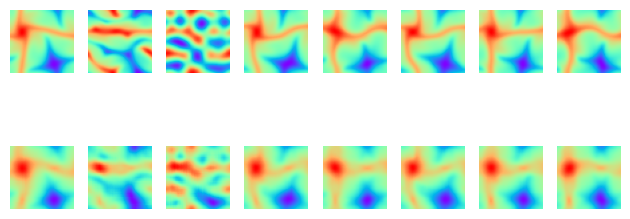

In [9]:
from matplotlib import pyplot as plt

snapshots_unstandardized = snapshots*standardization_std+standardization_mean
decoded_unstandardized = decoded*standardization_std+standardization_mean

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(snapshots_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(decoded_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()
plt.show()

### Animation

In [10]:
# use raw simulation data for animation since train/valid/test datasets are shuffled
def get_sim_data():
    sim_file = h5py.File(
    os.path.join('..', 'simulation', '3d', 'data', SIMULATION_NAME, 'sim1.h5'), 
    'r')
    return sim_file, sim_file['data']

PRED_BATCH_SIZE = 1024
def predict_batch(sim_data, i, size=PRED_BATCH_SIZE):
    """Calculates the models output of a batch of raw simulation data."""
    # prepare input
    orig = np.transpose(sim_data[:, :, :, :, i*size:(i+1)*size], [4,2,1,0,3])
    orig_standardized = np.divide((orig - standardization_mean), standardization_std, 
                                out=np.zeros_like(orig), where=standardization_std!=0)
    
    # predict
    pred_standardized = model.predict(orig_standardized)
    
    # retransform output
    pred_unstandardized = pred_standardized*standardization_std + standardization_mean
    return orig, pred_unstandardized

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def auto_encoder_animation(axis, animation_name, slice, fps):
    """Animates the output of a AE next to the input across a 2D slice.

    Args:
        axis: 0, 1, 2 for slices across the width, depth or height axis respectively
    """
    sim_file, sim_data = get_sim_data()
    
    batch_x, batch_y = predict_batch(sim_data, 0)
    current_batch_nr = 0

    # prepare plot
    fig = plt.figure()
    ax = plt.subplot(1,2,1)
    orig_im = plt.imshow(np.rot90(batch_x[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow')
    plt.axis('off')
    ax.set_title('input')

    ax = plt.subplot(1,2,2)
    pred_im = plt.imshow(np.rot90(batch_y[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow')
    plt.axis('off')
    ax.set_title('output')
    
    def frame_updater(frame):
        """Computes the next frame of the animation."""
        nonlocal batch_x, batch_y, current_batch_nr
        
        required_batch_nr, in_batch_frame = frame//PRED_BATCH_SIZE, frame%PRED_BATCH_SIZE
        if required_batch_nr > current_batch_nr:
            # required to predict next batch
            current_batch_nr = required_batch_nr
            batch_x, batch_y = predict_batch(sim_data, required_batch_nr)
            print(f'{current_batch_nr}/{sim_data.shape[-1]//PRED_BATCH_SIZE}')
        
        # update frames
        orig_data = np.rot90(batch_x[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        pred_data = np.rot90(batch_y[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        orig_im.set_array(orig_data)
        pred_im.set_array(pred_data)
        
        # update color map limits
        vmin = min(np.min(orig_data), np.min(pred_data))
        vmax = max(np.max(orig_data), np.max(pred_data))
        orig_im.set_clim(vmin=vmin, vmax=vmax)
        pred_im.set_clim(vmin=vmin, vmax=vmax)
        
        return orig_im, pred_im
    
    anim = animation.FuncAnimation(fig, frame_updater, frames=sim_data.shape[-1], interval=1000/fps, blit=True)
    anim.save(f'{animation_name}.mp4')
    
    sim_file.close()

**Width slice**

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step


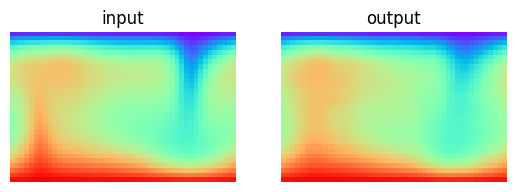

In [12]:
auto_encoder_animation(axis=0, animation_name='animations/width', slice=24, fps=30)

from IPython.display import Video
Video("animations/width.mp4")

**Depth slice**

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


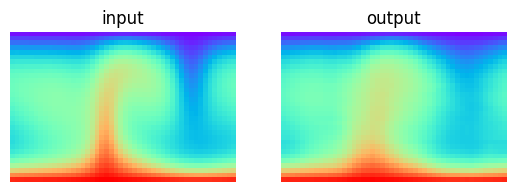

In [13]:
auto_encoder_animation(axis=1, animation_name='animations/depth', slice=24, fps=30)

from IPython.display import Video
Video("animations/depth.mp4")

**Height slice**

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


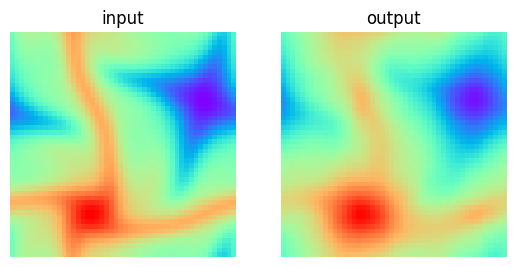

In [14]:
auto_encoder_animation(axis=2, animation_name='animations/height', slice=16, fps=30)

from IPython.display import Video
Video("animations/height.mp4")

In [20]:
import numpy as np

a = np.array([[1, 11], [2, 12]])
b = np.array([[3, 13], [4, 14]])
l = [a, b]

print(np.mean(l, axis=(0,-1))[..., np.newaxis])
print()
print(np.mean(np.concatenate([a, b], axis=-1), axis=-1, keepdims=True))

[[7.]
 [8.]]

[[7.]
 [8.]]
